In [79]:
from ortools.sat.python import cp_model
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random

# Yin-Yang Puzzle

[Yin-Yang](https://www.puzzle-yin-yang.com/) is a logic puzzle with simple rules and challenging solutions.

The rules are simple.Yin-Yang is played on a rectangular grid with no standard size. Some cells start out filled with black or white. The rest of the cells are empty. The goal is to color all cells in such a way that:
1. All black cells should be connected orthogonally in a single group.
2. All white cells should be connected orthogonally in a single group.
3. 2x2 areas of the same color are not allowed.

## Note
### Flow balance code used from [this post.](https://github.com/OptimizationExpert/Pyomo/blob/main/half_chess_board.ipynb)

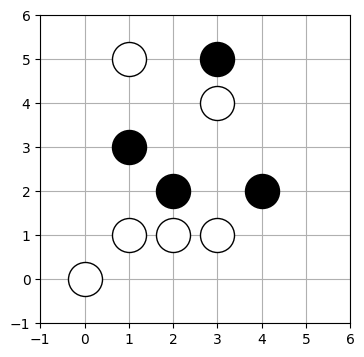

In [80]:
hint = [
[-1,0,-1,1,-1,-1],  
[-1,-1,-1,0,-1,-1],  
[-1,1,-1,-1,-1,-1],  
[-1,-1,1,-1,1,-1],  
[-1,0,0,0,-1,-1],  
[0,-1,-1,-1,-1,-1]  
]

n = 6
S = range(n)

color = {0: 'w', 1: 'k'}

plt.figure(figsize=((n+2)/2,(n+2)/2))

for i in S:
    for j in S:
        if hint[i][j] != -1:
            plt.scatter(j,n-i-1,marker='o', c = color[hint[i][j]], s = 600, edgecolor = 'k', zorder = 3)

plt.xlim(-1,n)
plt.ylim(-1,n)
plt.grid(True)

In [81]:
# Function tracking Euclidean distance between two cells
def dist(a,b,c,d):
    return int((c-a)**2 + (d-b)**2)

# Creates the model and set solver
model = cp_model.CpModel()
solver = cp_model.CpSolver()

C = ['black','white']

# Grid variables (1 if black, 0 if white)
x = {(i,j): model.NewBoolVar(f'x_{i}_{j}') for i in S for j in S} 

# Tracking demand between black and white cells
demand = {k: model.NewIntVar(1,n**2, f'demand_{k}') for k in C}

# Tracking source nodes between black and white cells
source = {k: {(i,j): model.NewBoolVar(f'source_{i}_{j}') for i in S for j in S} for k in C}

# Intermediary variable multiplying demand and source variables
ds =  {k: {(i,j): model.NewIntVar(0,n**2,f'ds_{i}_{j}') for i in S for j in S} for k in C}

# Flow balance variable between white and black cells
flow = {k: {((a,b),(c,d)): model.NewIntVar(0,n**2,f'flow_{a}_{b}_{c}_{d}') \
              for (a,b),(c,d) in (list(itertools.permutations(list(itertools.product(range(n), range(n))),2))) if dist(a,b,c,d) == 1} for k in C}

# Tracking if two cells are linked
link = {k: {((a,b),(c,d)): model.NewBoolVar(f'link_{a}_{b}_{c}_{d}') \
              for (a,b),(c,d) in (list(itertools.permutations(list(itertools.product(range(n), range(n))),2))) if dist(a,b,c,d) == 1} for k in C}

# Intermediary variable multiplying link and demand
dl = {k: {((a,b),(c,d)): model.NewIntVar(0,n**2,f'dl_{a}_{b}_{c}_{d}') \
            for (a,b),(c,d) in (list(itertools.permutations(list(itertools.product(range(n), range(n))),2))) if dist(a,b,c,d) == 1} for k in C}

# Tracking 2x2 area
area = [(0,0),(0,1),(1,0),(1,1)]

for i in S:
    for j in S:
        if hint[i][j] != -1:
            # Initializing grid with hints
            model.Add(x[i,j] == hint[i][j])

for i in range(n-1):
    for j in range(n-1):
        # 2x2 areas of the same color not allowed
        model.Add(sum(x[i+a,j+b] for a,b in area) > 0)
        model.Add(sum(x[i+a,j+b] for a,b in area) < 4)

# Demand equal to the number of black and white cells, respectively        
model.Add(sum(x[j,k] for j in S for k in S) == demand['black'])
model.Add(demand['white'] == n**2 - demand['black'])

for i in C:
    # Only one source node per color
    model.AddExactlyOne([source[i][j,k] for j in S for k in S])

    for j in S:
        for k in S:

            # Nodal constraint
            model.AddMultiplicationEquality(ds[i][j,k], demand[i], source[i][j,k])
            
            if i == 'black':
                # If black source node, then that cell must be black
                model.Add(source[i][j,k] <= x[j,k])

                # Flow balance equation
                model.Add(ds[i][j,k] - (x[j,k]) == \
                      sum(flow[i][((j,k),(c,d))] - flow[i][((c,d),(j,k))] for c in S for d in S if ((j,k),(c,d)) in flow[i]))\
                        .OnlyEnforceIf(x[j,k])
            else:
                # If white source node, then that cell must be white
                model.Add(source[i][j,k] <= 1 - x[j,k])
                
                # Flow balance equation
                model.Add(ds[i][j,k] - (1-x[j,k]) == \
                        sum(flow[i][((j,k),(c,d))] - flow[i][((c,d),(j,k))] for c in S for d in S if ((j,k),(c,d)) in flow[i]))\
                            .OnlyEnforceIf(x[j,k].Not())

    for (j,k),(a,b) in (list(itertools.permutations(list(itertools.product(range(n), range(n))),2))):

        if dist(j,k,a,b) == 1:
            
            model.AddMultiplicationEquality(dl[i][((j,k),(a,b))], demand[i], link[i][((j,k),(a,b))])

            if i == 'black':
                # Flow cannot exceed demand
                model.Add(flow[i][((j,k),(a,b))] <= dl[i][((j,k),(a,b))])

                # If two cells linked, then both should be black
                model.Add(link[i][((j,k),(a,b))] <= x[j,k])
                model.Add(link[i][((j,k),(a,b))] <= x[a,b])

                # No flow between unlinked black pairs
                model.Add(flow[i][((j,k),(a,b))] == 0).OnlyEnforceIf(link[i][((j,k),(a,b))].Not())
            else:
                # Flow cannot exceed demand
                model.Add(flow[i][((j,k),(a,b))] <= dl[i][((j,k),(a,b))])

                # If two cells linked, then both should be white
                model.Add(link[i][((j,k),(a,b))] <= 1 - x[j,k])
                model.Add(link[i][((j,k),(a,b))] <= 1 - x[a,b])

                # No flow between unlinked white pairs
                model.Add(flow[i][((j,k),(a,b))] == 0).OnlyEnforceIf(link[i][((j,k),(a,b))].Not())

status = solver.Solve(model)
print(f'Status = {solver.StatusName(status)}')

Status = OPTIMAL


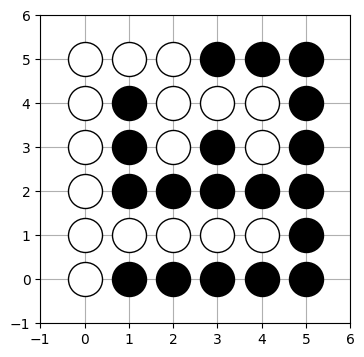

In [82]:
sol = [solver.value(x[i,j]) for i,j in x]
sol = np.reshape(sol,(n,n))

color = {0: 'w', 1: 'k'}
plt.figure(figsize=((n+2)/2,(n+2)/2))

for i in S:
    for j in S:
        plt.scatter(j,n-i-1,marker='o', c = color[sol[i,j]], s = 600, edgecolor = 'k', zorder = 3)

plt.xlim(-1,n)
plt.ylim(-1,n)
plt.grid(True)